In [27]:
import numpy as np
import pandas as pd

from gensim.models import FastText
from gensim.test.utils import common_texts
from gensim.utils import tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence

# PREPARE DATA TO AUTOENCODER

In [2]:
train = pd.read_csv('../../data/interim/cadec/train.csv')
test = pd.read_csv('../../data/interim/cadec/test.csv')

In [3]:
sentences = pd.read_csv('../../data/interim/cadec/test.csv')['text'].apply(
                lambda x: x.lower().split('<SENT>')).explode().apply(lambda x: list(tokenize(x))).to_list()

max_seq_len = 10
embed_dim = 150
nb_words = 3000

ftmodel = FastText(size=embed_dim, window=5, min_count=1)
ftmodel.build_vocab(sentences=sentences)
ftmodel.train(sentences=sentences, total_examples=len(sentences), epochs=10)

In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=nb_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False
)

tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

nb_words = min(nb_words, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ftmodel[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        
word_seq_train = tokenizer.texts_to_sequences(train['term'])
word_seq_test = tokenizer.texts_to_sequences(test['term'])

X_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
X_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

labels = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
labels = labels['CODE']
meddra_labels = {v:k for k, v in enumerate(labels.unique())}

y_train = train['code'].apply(lambda x: meddra_labels[x]).to_numpy()
y_test = test['code'].apply(lambda x: meddra_labels[x]).to_numpy()

number_of_classes = labels.unique().shape[0]

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [5]:
X_train.shape, X_test.shape

((3520, 10), (881, 10))

# MODEL



In [11]:
import keras
from keras import layers, Model
from keras.utils import to_categorical 


vocab_size = nb_words
src_txt_length = max_seq_len
sum_txt_length = max_seq_len

# encoder input model
inputs = layers.Input(shape=(src_txt_length,))
encoder1 = layers.Embedding(nb_words, embed_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix],trainable=False)(inputs)
encoder2 = layers.Bidirectional(layers.LSTM(256))(encoder1)
encoder3 = layers.RepeatVector(sum_txt_length)(encoder2)

# decoder output model
decoder1 = layers.LSTM(256, return_sequences=True)(encoder3)
outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(decoder1)

# tie it together
model = Model(inputs=inputs, outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001,)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 150)           450000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               833536    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 256)           787456    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 3000)          771000    
Total params: 2,841,992
Trainable params: 2,391,992
Non-trainable params: 450,000
___________________________________________

In [16]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

history = model.fit(
    X_train, 
    to_categorical(X_train, num_classes=nb_words),
    epochs=30,
    steps_per_epoch=20,
    validation_data=(X_test, to_categorical(X_test, num_classes=nb_words)),
    callbacks=[earlystopping]
)

Epoch 1/30
20/20 [==============================] - 3s 138ms/step - loss: 1.6772 - val_loss: 1.7412
Epoch 2/30
20/20 [==============================] - 2s 126ms/step - loss: 1.6520 - val_loss: 1.7250
Epoch 3/30
20/20 [==============================] - 3s 132ms/step - loss: 1.6337 - val_loss: 1.7004
Epoch 4/30
20/20 [==============================] - 3s 133ms/step - loss: 1.6059 - val_loss: 1.6818
Epoch 5/30
20/20 [==============================] - 3s 130ms/step - loss: 1.5951 - val_loss: 1.6743
Epoch 6/30
20/20 [==============================] - 3s 128ms/step - loss: 1.5793 - val_loss: 1.6546
Epoch 7/30
20/20 [==============================] - 2s 123ms/step - loss: 1.6299 - val_loss: 1.6632
Epoch 8/30
20/20 [==============================] - 2s 124ms/step - loss: 1.5918 - val_loss: 1.6560
Epoch 9/30
20/20 [==============================] - 3s 132ms/step - loss: 1.5652 - val_loss: 1.6285
Epoch 10/30
20/20 [==============================] - 2s 126ms/step - loss: 1.5519 - val_loss: 1.6222

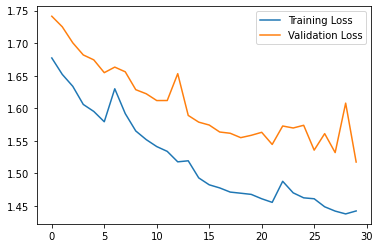

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [18]:
text = ['sick of this pain my back']
tokenized = tokenizer.texts_to_sequences(text)
tokenized = sequence.pad_sequences(tokenized, maxlen=max_seq_len)
tokenizer.sequences_to_texts(tokenized), tokenized

(['sick of this pain my back'],
 array([[  0,   0,   0,   0, 666,   8,  16,  11,   6,  30]], dtype=int32))

In [19]:
import numpy as np
predicted = [np.argmax(i) for i in model.predict(tokenized)[0]]
tokenizer.sequences_to_texts([predicted])

['pain pain pain pain pain']

# Get encoder

In [26]:
encoder = keras.Sequential(model.layers[:4])
encoder.predict(tokenized).shape

(1, 10, 512)

In [31]:
encoder.save('../../models/encoder_cadec.h5')

In [32]:
encoder_loaded = keras.models.load_model('../../models/encoder_cadec.h5')

In [33]:
encoder_loaded.predict(tokenized).shape

(1, 10, 512)